In [118]:
# reload all modules before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import *

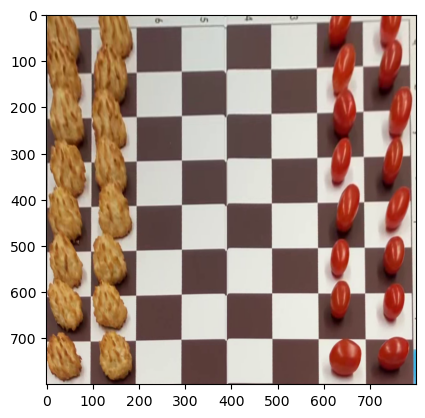

In [120]:
img = cv2.imread('../img_test/warped_frame_2.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [122]:
# convert to grayscale and detect edges
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# automatic Canny thresholds based on median
med = np.median(blur)
lower = int(max(0, 0.66 * med))
upper = int(min(255, 1.33 * med))
edges = cv2.Canny(blur, lower, upper)

In [123]:
# probabilistic Hough line transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80,
                        minLineLength=60, maxLineGap=20)

# draw detected lines on a copy of the image
line_img = img.copy()
if lines is None:
    exit("No lines detected")

print(f"Detected {len(lines)} line segments.")
print(lines.shape)  # (N, 1, 4) : N lines, each with 4 coords (x1, y1, x2, y2)

segs = lines.reshape(-1, 4)
# compute direction vectors of each segment by (x2 - x1, y2 - y1)
vecs = segs[:, 2:4] - segs[:, :2]
print(vecs.shape)  # (N, 2) : N vectors, each with 2 components (dx, dy)

# compute angle of each segment
dx, dy = vecs[:, 0].astype(float), vecs[:, 1].astype(float)
angles = np.arctan2(dy, dx)
tol = np.deg2rad(1)  # tolerance for "almost perpendicular" (10 degrees) : n * pi/180

for i, (x1, y1, x2, y2) in enumerate(segs):
    angle = angles[i]
    # check if there's any other line almost perpendicular to this one
    perp = False
    for j, a2 in enumerate(angles):
        if i == j:
            continue
        if abs(abs(angle - a2) - np.pi/2) < tol:
            perp = True
            break
    color = GREEN if perp else RED
    cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 5)

Detected 66 line segments.
(66, 1, 4)
(66, 2)


In [124]:
line_img2 = img.copy()

# extend detected nearly-vertical and nearly-horizontal segments to full image borders to form a grid
h, w = img.shape[:2]
class_tol = np.deg2rad(1)  # classify lines within 15 degrees as horizontal/vertical

# get indices of lines with +- 15dg vert or horiz
vert_idx = np.where(np.abs(np.abs(angles) - np.pi/2) < class_tol)[0]
horiz_idx = np.where(np.abs(angles) < class_tol)[0]
print(f"Number of vertical lines: {len(vert_idx)}")
print(f"Number of horizontal lines: {len(horiz_idx)}")

# use segs to define a x-y axis system based on midpoints of detected segments
xs = np.array([(segs[i, 0] + segs[i, 2]) / 2.0 for i in vert_idx]) if vert_idx.size else np.array([])
ys = np.array([(segs[i, 1] + segs[i, 3]) / 2.0 for i in horiz_idx]) if horiz_idx.size else np.array([])

# visualize raw xs and ys positions on line_img2
for xv in xs:
    x = int(round(np.clip(xv, 0, w - 1)))
    cv2.circle(line_img2, (x, h // 2), 8, RED, -1)
    cv2.putText(line_img2, str(int(x)), (x + 6, h // 2 - 6),
            cv2.FONT_HERSHEY_SIMPLEX, 0.4, WHITE, 1, cv2.LINE_AA)

for yv in ys:
    y = int(round(np.clip(yv, 0, h - 1)))
    cv2.circle(line_img2, (w // 2, y), 8, GREEN, -1)
    cv2.putText(line_img2, str(int(y)), (w // 2 + 6, y - 6),
            cv2.FONT_HERSHEY_SIMPLEX, 0.4, WHITE, 1, cv2.LINE_AA)

# cluster close lines to avoid duplicate nearby grid lines
def cluster_1d(vals, eps=10):
    if vals.size == 0:
        return np.array([])
    vals = vals.reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=1).fit(vals)
    clusters = []
    for lab in np.unique(clustering.labels_):
        members = vals[clustering.labels_ == lab].flatten()
        clusters.append(members.mean())
    return np.array(sorted(clusters))

x_lines = cluster_1d(xs, eps=12)
y_lines = cluster_1d(ys, eps=12)
print(f"Number of vertical lines clustered: {len(x_lines)}")
print(f"Number of horizontal lines clustered: {len(y_lines)}")

# draw intersection points
inters_pts = []
for xv in x_lines:
    for yv in y_lines:
        xi = int(round(np.clip(xv, 0, w-1)))
        yi = int(round(np.clip(yv, 0, h-1)))
        inters_pts.append((xi, yi))

external_pts = [
    (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
    (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
    (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1)))),
    (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1))))
]

min_x, max_x, min_y, max_y = external_pts[0][0], external_pts[3][0], external_pts[0][1], external_pts[3][1]

for xv in x_lines:
    x = int(round(np.clip(xv, 0, w-1)))
    # cv2.line(line_img2, (x, 0), (x, h-1), BLUE, 2)
    cv2.line(line_img2, (x, min_y), (x, max_y), BLUE, 2)

for yv in y_lines:
    y = int(round(np.clip(yv, 0, h-1)))
    # cv2.line(line_img2, (0, y), (w-1, y), BLUE, 2)
    cv2.line(line_img2, (min_x, y), (max_x, y), BLUE, 2)

for (xi, yi) in inters_pts:
    cv2.circle(line_img2, (xi, yi), 6, ORANGE, -1)


for i, (xi, yi) in enumerate(external_pts):
    cv2.circle(line_img2, (xi, yi), 6, BLACK, 4)

print(f"Drawn {len(x_lines)} vertical and {len(y_lines)} horizontal grid lines -> {len(x_lines)*len(y_lines)} intersections")

Number of vertical lines: 36
Number of horizontal lines: 20
Number of vertical lines clustered: 9
Number of horizontal lines clustered: 9
Drawn 9 vertical and 9 horizontal grid lines -> 81 intersections


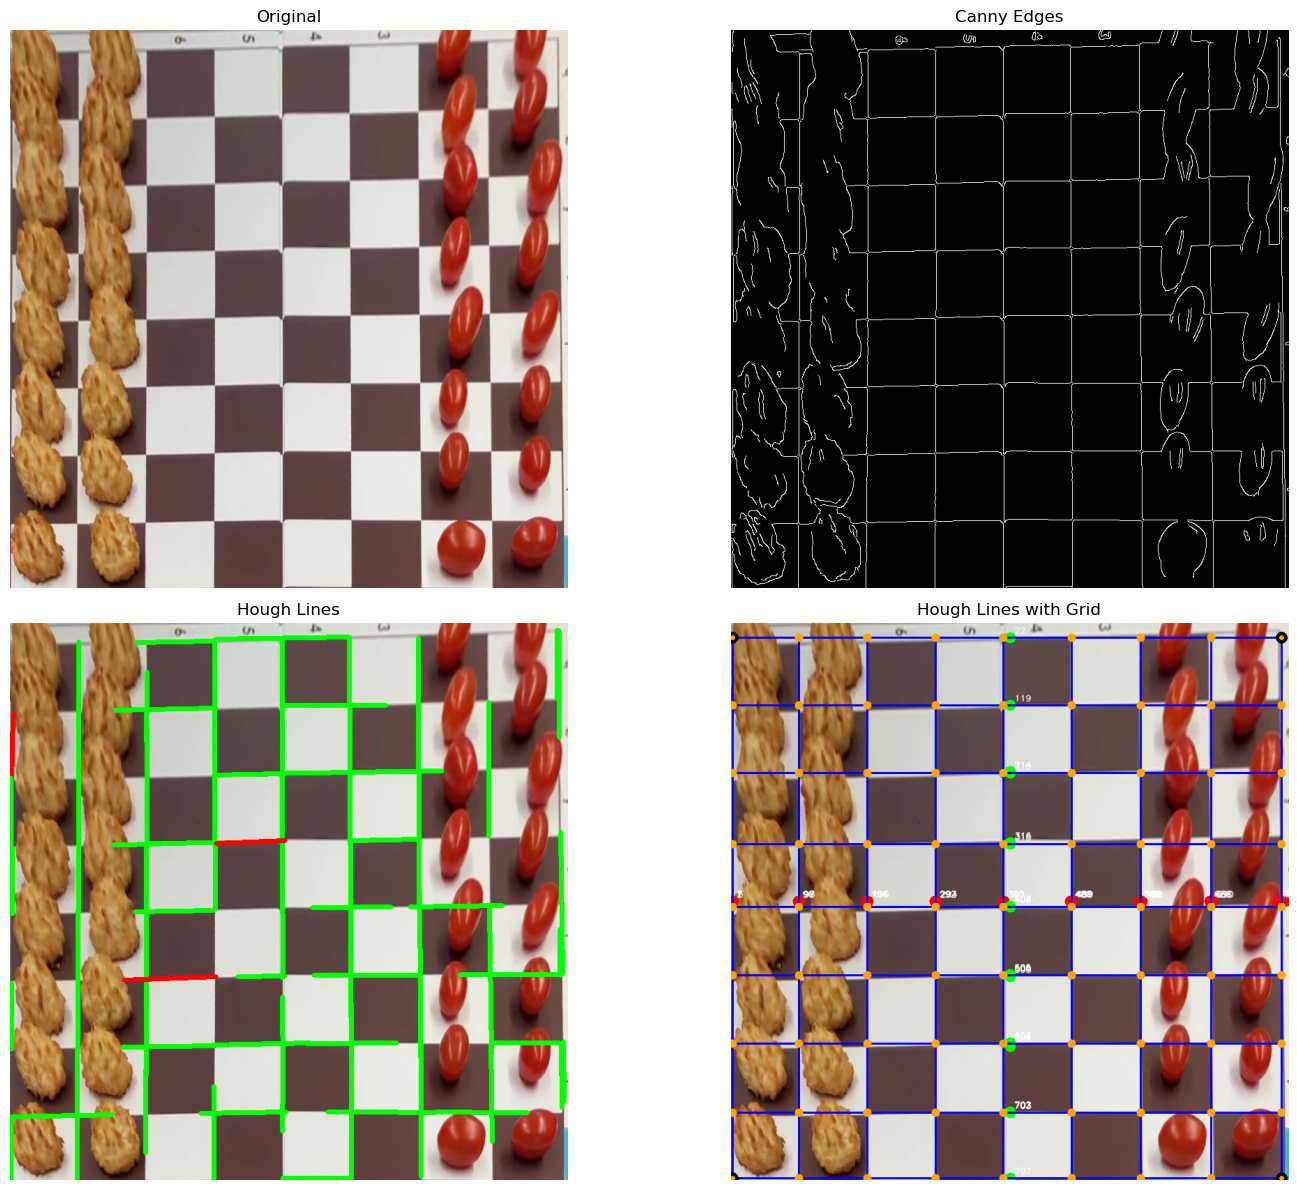

In [125]:
# show original, edges, and result
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original')
axs[0, 0].axis('off')

axs[0, 1].imshow(edges, cmap='gray')
axs[0, 1].set_title('Canny Edges')
axs[0, 1].axis('off')

axs[1, 0].imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Hough Lines')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(line_img2, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Hough Lines with Grid')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()